# Target areas for opening a gym in Frankfurt
## Assignment: Final project in Capstone Project
(for IBM Data Science Professional Certificate)

### Note: Github repository and NBViewer

This notebook uses many Choropleth maps which are not rendered by <b>Github</b> itself. However, they are rendered properly using <b>NBViewer</b>.

Please use the following link to access the <b>Github</b> directory: <a href='https://github.com/rolandteschke/Coursera_Capstone'>https://github.com/rolandteschke/Coursera_Capstone</a>

### Import libraries

In [1]:
# Self-defined library to use some sensitive data
import sensitivedata
sensitivedata.corporate_environment_connection() # setup proxy connections in corporate environment

# Get Foursquare credentials from my self-defined class so that my credentials are kept secret when I publish this notebook
CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN = sensitivedata.my_foursquare_credentials()

# Data processing and visualization libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize

# Location and maps
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geojson
from geojson_utils import centroid
import requests # library to handle requests
import folium # map rendering library
from folium import plugins
from shapely.geometry import shape, Point


# Data analysis
import sklearn
import sklearn.metrics
from sklearn.cluster import KMeans, DBSCAN

# Show all data when displaying dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Retrieve GEOJson data of Frankfurt to determine boroughs geographically

In [2]:
# Import the geojson file for the shapes of all Frankfurt boroughs
with open('data/Stadtteile_-_Frankfurt_am_Main.geojson',encoding='utf_8') as json_file:
    ffm_boroughs_shape = json.load(json_file)
    
# Create dataframe from GEOJson file
ffm_boroughs_shape_df = pd.DataFrame(ffm_boroughs_shape['features'])
ffm_boroughs_shape_df = pd.json_normalize(ffm_boroughs_shape['features'])

In [3]:
ffm_boroughs_shape_df.head()

type  properties.FID  properties.STTLNR properties.STTLNAME  \
0  Feature               1                1.0            Altstadt   
1  Feature               2                2.0          Innenstadt   
2  Feature               3                3.0     Bahnhofsviertel   
3  Feature               4                4.0         Westend-Süd   
4  Feature               5                5.0        Westend-Nord   

   properties.SHAPE_Length  properties.SHAPE_Area geometry.type  \
0                 0.038069               0.000064  MultiPolygon   
1                 0.087614               0.000187  MultiPolygon   
2                 0.036492               0.000068  MultiPolygon   
3                 0.098650               0.000314  MultiPolygon   
4                 0.064831               0.000205  MultiPolygon   

                                geometry.coordinates  
0  [[[[8.677440379000075, 50.10667295600007], [8....  
1  [[[[8.686828500000047, 50.12012602400006], [8....  
2  [[[[8.661996516000045, 50.10882462700005], [8....  
3  [[[[8.660698715000024, 50.12310305700004], [8....  
4  [[[[8.671130134000066, 50.136955699000055], [8...

### Calculate borough center locations based on borough geo shape data

In [4]:
# Create col for longitude centroid
if ('centroid.longitude' in ffm_boroughs_shape_df.columns)==False:
    ffm_boroughs_shape_df.insert(loc=6,column='centroid.longitude',value=np.NaN)

# Create col for latitude centroid
if ('centroid.latitude' in ffm_boroughs_shape_df.columns)==False:
    ffm_boroughs_shape_df.insert(loc=6,column='centroid.latitude',value=np.NaN)

# Create a temporary dataframe only with geoshapes to pre-process them further
temp_df = pd.DataFrame(ffm_boroughs_shape_df['geometry.coordinates'])

# Calculate geo-centroid coordinates as the center between a boroughs min and max coordinates, and assign them to the original dataframe
for ind, row in temp_df.iterrows():
    borough_values = row[0][0][0]
    long_values = np.array(borough_values)[:,0]
    lat_values = np.array(borough_values)[:,1]
    center_long = (np.min(long_values) + np.max(long_values)) / 2
    center_lat = (np.min(lat_values) + np.max(lat_values)) / 2
    ffm_boroughs_shape_df.loc[ind,'centroid.longitude'] = center_long
    ffm_boroughs_shape_df.loc[ind,'centroid.latitude'] = center_lat

In [5]:
ffm_boroughs_shape_df.head()

type  properties.FID  properties.STTLNR properties.STTLNAME  \
0  Feature               1                1.0            Altstadt   
1  Feature               2                2.0          Innenstadt   
2  Feature               3                3.0     Bahnhofsviertel   
3  Feature               4                4.0         Westend-Süd   
4  Feature               5                5.0        Westend-Nord   

   properties.SHAPE_Length  properties.SHAPE_Area  centroid.latitude  \
0                 0.038069               0.000064          50.110590   
1                 0.087614               0.000187          50.112816   
2                 0.036492               0.000068          50.107810   
3                 0.098650               0.000314          50.117951   
4                 0.064831               0.000205          50.129776   

   centroid.longitude geometry.type  \
0            8.681539  MultiPolygon   
1            8.682204  MultiPolygon   
2            8.667658  MultiPolygon   
3            8.661165  MultiPolygon   
4            8.666019  MultiPolygon   

                                geometry.coordinates  
0  [[[[8.677440379000075, 50.10667295600007], [8....  
1  [[[[8.686828500000047, 50.12012602400006], [8....  
2  [[[[8.661996516000045, 50.10882462700005], [8....  
3  [[[[8.660698715000024, 50.12310305700004], [8....  
4  [[[[8.671130134000066, 50.136955699000055], [8...

### Retrieve location data from Foursquare for category 'gym' in all boroughs in Frankfurt, Germany

In [6]:
LIMIT=100
VERSION= '20200128'
category = '4bf58dd8d48988d175941735'

# function to retrieve venues for each location
def get_gyms(longitude,latitude):
    long_lat = str(longitude) + str(', ') + str(latitude)
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        long_lat,
        category,
        LIMIT
        )
    
    results = requests.get(url).json()["response"]["groups"][0]["items"]
    results_df = pd.json_normalize(results)
    results_df.head()
    return results_df

In [7]:
# Request gym venues for all boroughs and create dataframe
df_gyms = pd.DataFrame()

for ind, row in ffm_boroughs_shape_df.iterrows():
    result = pd.DataFrame()
    result = get_gyms(ffm_boroughs_shape_df.loc[ind,'centroid.latitude'],ffm_boroughs_shape_df.loc[ind,'centroid.longitude'])
    df_gyms = df_gyms.append(result)

In [8]:
df_gyms.head(2)

referralId  reasons.count  \
0  e-0-53e223cf498e2cf5740be372-0              0   
1  e-0-54f32683498ee0f30aff5175-1              0   

                                       reasons.items  \
0  [{'summary': 'This spot is popular', 'type': '...   
1  [{'summary': 'This spot is popular', 'type': '...   

                   venue.id           venue.name venue.location.address  \
0  53e223cf498e2cf5740be372  FITSEVENELEVEN Zeil               Zeil 105   
1  54f32683498ee0f30aff5175             ELEMENTS                    NaN   

   venue.location.lat  venue.location.lng  \
0           50.114163            8.682001   
1           50.116959            8.680101   

                       venue.location.labeledLatLngs  venue.location.distance  \
0  [{'label': 'display', 'lat': 50.11416297949645...                      399   
1  [{'label': 'display', 'lat': 50.11695937946801...                      716   

  venue.location.postalCode venue.location.cc venue.location.city  \
0                     60313                DE   Frankfurt am Main   
1                       NaN                DE   Frankfurt am Main   

  venue.location.state venue.location.country  \
0               Hessen            Deutschland   
1               Hessen            Deutschland   

                    venue.location.formattedAddress  \
0  [Zeil 105, 60313 Frankfurt am Main, Deutschland]   
1                  [Frankfurt am Main, Deutschland]   

                                    venue.categories  venue.photos.count  \
0  [{'id': '4bf58dd8d48988d175941735', 'name': 'G...                   0   
1  [{'id': '4bf58dd8d48988d175941735', 'name': 'G...                   0   

  venue.photos.groups flags.outsideRadius venue.location.crossStreet  \
0                  []                 NaN                        NaN   
1                  []                 NaN                        NaN   

  venue.venuePage.id  
0                NaN  
1                NaN

In [9]:
# Drop duplicate venues since the radius of the boroughs might overlap and a venue might have been listed several times
df_gyms = df_gyms.drop_duplicates(subset='venue.id')

In [10]:
# Inspect the number of unqiue gym entries retrieved - in fact, this looks very reasonable for a city as large as Frankfurt
df_gyms.shape

(206, 22)

In [11]:
# Ensure to have a proper index in the dataframe for later processing
df_gyms = df_gyms.reset_index()

### Deterimne the gym (sub-)category based on the Foursquare data

In [12]:
# Create a temporary dataframe only with geoshapes to pre-process them further
temp_df = pd.DataFrame(df_gyms['venue.categories'])

# Clean up venue categories since the foursquare API returns a mixture of different results structures.
for ind, row in temp_df.iterrows():
    condition1 = isinstance(row[0],(str))
    condition2 = isinstance(row[0],(list,dict))
    counter = 0
    if (condition1):
        venuecat=row[0]
    else:
        if (condition2):
            venuecat=row[0][0]['name']
        else:
            venuecat=type(row[0][0])

    df_gyms.loc[ind,'venue.category.clean']= venuecat

### Determine whether the gyms are located in Frankfurt, or outside of Frankfurt

In [13]:
# Determine whether a gym location is within the Frankfurt boroughs or not, based on the GEOjson shapes
def isgym_in_ffm(long,lat):
    # construct point based on lon/lat returned by geocoder
    point = Point(long,lat)

    # check each polygon to see if it contains the point
    for feature in ffm_boroughs_shape['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return True
        else:
            bool_result = False
    return bool_result

# Populate the dataframe with the results for each gym
for ind, row in df_gyms.iterrows():
    result = isgym_in_ffm(df_gyms.loc[ind,'venue.location.lng'],df_gyms.loc[ind,'venue.location.lat'])
    df_gyms.loc[ind,'in_ffm'] = result

In [14]:
df_gyms.groupby('in_ffm')['venue.id'].nunique()

in_ffm
False     81
True     125
Name: venue.id, dtype: int64

### Determine in which specific borough of Frankfurt each gyms is located

In [15]:
# Determine in which borough a gym is located
def gym_borough(long,lat):
    # construct point based on lon/lat returned by geocoder
    point = Point(long,lat)

    # check each polygon to see if it contains the point
    for feature in ffm_boroughs_shape['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            # if point is in borugh, return both borough name and borough code (code will be needed later to join with additional data source)
            return feature['properties']['STTLNAME'] , feature['properties']['STTLNR'] 
        else:
            bool_result = np.NaN
    return bool_result, bool_result

# gym_borough(df_gyms.loc[0,'venue.location.lng'],df_gyms.loc[0,'venue.location.lat'])

# Populate the dataframe with the results for each gym
for ind, row in df_gyms.iterrows():
    result1, result2 = gym_borough(df_gyms.loc[ind,'venue.location.lng'],df_gyms.loc[ind,'venue.location.lat'])
    df_gyms.loc[ind,'properties.STTLNAME'] = result1
    df_gyms.loc[ind,'properties.STTLNR'] = result2

In [16]:
# Show a quick summary / see visualization
# df_gyms.groupby('properties.STTLNAME')['venue.id'].nunique()

### Compute the number of gyms per borough and add it to the boroughs dataframe

In [17]:
df_gyms.head()

index                      referralId  reasons.count  \
0      0  e-0-53e223cf498e2cf5740be372-0              0   
1      1  e-0-54f32683498ee0f30aff5175-1              0   
2      2  e-0-56d5a622cd10df88a9246da8-2              0   
3      3  e-0-4bbf8c5d74a9a593aca4cef6-3              0   
4      4  e-0-4bbd5e00a0a0c9b681a01b0f-4              0   

                                       reasons.items  \
0  [{'summary': 'This spot is popular', 'type': '...   
1  [{'summary': 'This spot is popular', 'type': '...   
2  [{'summary': 'This spot is popular', 'type': '...   
3  [{'summary': 'This spot is popular', 'type': '...   
4  [{'summary': 'This spot is popular', 'type': '...   

                   venue.id                        venue.name  \
0  53e223cf498e2cf5740be372               FITSEVENELEVEN Zeil   
1  54f32683498ee0f30aff5175                          ELEMENTS   
2  56d5a622cd10df88a9246da8                     Fitness First   
3  4bbf8c5d74a9a593aca4cef6  Fitness First Platinum Swim Club   
4  4bbd5e00a0a0c9b681a01b0f    Fitness First Black Label Club   

  venue.location.address  venue.location.lat  venue.location.lng  \
0               Zeil 105           50.114163            8.682001   
1                    NaN           50.116959            8.680101   
2            Hochstr. 44           50.116017            8.674120   
3           Zeil 102/106           50.114520            8.681247   
4         Hochstraße 2-4           50.116760            8.676590   

                       venue.location.labeledLatLngs  venue.location.distance  \
0  [{'label': 'display', 'lat': 50.11416297949645...                      399   
1  [{'label': 'display', 'lat': 50.11695937946801...                      716   
2  [{'label': 'display', 'lat': 50.11601706964874...                      803   
3  [{'label': 'display', 'lat': 50.11452, 'lng': ...                      437   
4  [{'label': 'display', 'lat': 50.11675968060107...                      772   

  venue.location.postalCode venue.location.cc venue.location.city  \
0                     60313                DE   Frankfurt am Main   
1                       NaN                DE   Frankfurt am Main   
2                     60313                DE   Frankfurt am Main   
3                     60313                DE   Frankfurt am Main   
4                     60313                DE   Frankfurt am Main   

  venue.location.state venue.location.country  \
0               Hessen            Deutschland   
1               Hessen            Deutschland   
2               Hessen            Deutschland   
3               Hessen            Deutschland   
4               Hessen            Deutschland   

                     venue.location.formattedAddress  \
0   [Zeil 105, 60313 Frankfurt am Main, Deutschland]   
1                   [Frankfurt am Main, Deutschland]   
2  [Hochstr. 44, 60313 Frankfurt am Main, Deutsch...   
3  [Zeil 102/106, 60313 Frankfurt am Main, Deutsc...   
4  [Hochstraße 2-4, 60313 Frankfurt am Main, Deut...   

                                    venue.categories  venue.photos.count  \
0  [{'id': '4bf58dd8d48988d175941735', 'name': 'G...                   0   
1  [{'id': '4bf58dd8d48988d175941735', 'name': 'G...                   0   
2  [{'id': '4bf58dd8d48988d175941735', 'name': 'G...                   0   
3  [{'id': '4bf58dd8d48988d175941735', 'name': 'G...                   0   
4  [{'id': '4bf58dd8d48988d175941735', 'name': 'G...                   0   

  venue.photos.groups flags.outsideRadius venue.location.crossStreet  \
0                  []                 NaN                        NaN   
1                  []                 NaN                        NaN   
2                  []                True                        NaN   
3                  []                 NaN                        NaN   
4                  []                 NaN                        NaN   

  venue.venuePage.id  venue.category.clean in_ffm properties.STTLNAME  \
0             

In [18]:
ffm_boroughs_shape_df.shape

(46, 10)

In [19]:
# Compute the number of gyms per borough
df_temp = pd.DataFrame(df_gyms.groupby('properties.STTLNAME')['venue.id'].nunique())
df_temp.rename(columns={'venue.id':'Number of gyms'},inplace=True)
ffm_boroughs_shape_df = pd.merge(ffm_boroughs_shape_df, df_temp, on=['properties.STTLNAME'],how='outer')
# If no gyms were found, put the number to 0 instead of NaN
ffm_boroughs_shape_df['Number of gyms'].fillna(0,inplace=True)

In [20]:
# Show top5 boroughs with regards to number of gyms
ffm_boroughs_shape_df.sort_values('Number of gyms',ascending=False).head()

type  properties.FID  properties.STTLNR properties.STTLNAME  \
1   Feature               2                2.0          Innenstadt   
3   Feature               4                4.0         Westend-Süd   
12  Feature              13               13.0    Sachsenhausen-N.   
5   Feature               6                6.0        Nordend-West   
8   Feature               9                9.0            Bornheim   

    properties.SHAPE_Length  properties.SHAPE_Area  centroid.latitude  \
1                  0.087614               0.000187          50.112816   
3                  0.098650               0.000314          50.117951   
12                 0.143763               0.000532          50.098492   
5                  0.092290               0.000390          50.130401   
8                  0.095478               0.000350          50.132859   

    centroid.longitude geometry.type  \
1             8.682204  MultiPolygon   
3             8.661165  MultiPolygon   
12            8.685992  MultiPolygon   
5             8.685188  MultiPolygon   
8             8.711984  MultiPolygon   

                                 geometry.coordinates  Number of gyms  
1   [[[[8.686828500000047, 50.12012602400006], [8....            22.0  
3   [[[[8.660698715000024, 50.12310305700004], [8....            14.0  
12  [[[[8.718212175000076, 50.102429803000064], [8...            12.0  
5   [[[[8.697221435000074, 50.13691928500003], [8....             8.0  
8   [[[[8.705665758000066, 50.12288979900006], [8....             8.0

### Import statistical data about Frankfurt boroughs and merge it with the dataframe containing Frankfurt geo shapes and number of gyms

In [21]:
# Import relevant statistical data about Frankfurt boroughs
ffm_stats = pd.read_excel('data/Stadtteile_FFM_sliced.xlsx')
ffm_stats.rename(columns={'Stadtteil':'properties.STTLNAME'},inplace=True)
ffm_stats.rename(columns={'Codes':'properties.STTLNR'},inplace=True)

<ipython-input-21-ff4b2076c533>:2: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  ffm_stats = pd.read_excel('data/Stadtteile_FFM_sliced.xlsx')


In [22]:
# Merge the Frankfurt boroughs geospatial data with the statistics data
ffm_boroughs_shape_df = pd.merge(ffm_boroughs_shape_df, ffm_stats, on=['properties.STTLNR'], how='outer')

In [23]:
# After inspecting the outer join, it is visible that the borough "Airport" is not in the statistical data. The original bourough name label column gets renamed to the original value.   
ffm_boroughs_shape_df.rename(columns={'properties.STTLNAME_x':'properties.STTLNAME'}, inplace=True)
ffm_boroughs_shape_df.head()

type  properties.FID  properties.STTLNR properties.STTLNAME  \
0  Feature               1                1.0            Altstadt   
1  Feature               2                2.0          Innenstadt   
2  Feature               3                3.0     Bahnhofsviertel   
3  Feature               4                4.0         Westend-Süd   
4  Feature               5                5.0        Westend-Nord   

   properties.SHAPE_Length  properties.SHAPE_Area  centroid.latitude  \
0                 0.038069               0.000064          50.110590   
1                 0.087614               0.000187          50.112816   
2                 0.036492               0.000068          50.107810   
3                 0.098650               0.000314          50.117951   
4                 0.064831               0.000205          50.129776   

   centroid.longitude geometry.type  \
0            8.681539  MultiPolygon   
1            8.682204  MultiPolygon   
2            8.667658  MultiPolygon   
3            8.661165  MultiPolygon   
4            8.666019  MultiPolygon   

                                geometry.coordinates  Number of gyms  \
0  [[[[8.677440379000075, 50.10667295600007], [8....             1.0   
1  [[[[8.686828500000047, 50.12012602400006], [8....            22.0   
2  [[[[8.661996516000045, 50.10882462700005], [8....             1.0   
3  [[[[8.660698715000024, 50.12310305700004], [8....            14.0   
4  [[[[8.671130134000066, 50.136955699000055], [8...             3.0   

  properties.STTLNAME_y  Gesamtfläche  Sport-, Freizeit- und Erholungsfläche  \
0              Altstadt     50.618185                               1.919209   
1            Innenstadt    149.107237                              26.293493   
2       Bahnhofsviertel     54.182033                               2.562663   
3           Westend-Süd    249.698625                              23.123114   
4          Westend-Nord    163.206039                              34.441587   

   Haushalte  Einwohnerinnen und Einwohner  weiblich  männlich  \
0     2683.0                        4218.0    2065.0    2153.0   
1     4389.0                        6599.0    3112.0    3487.0   
2     2349.0                        3552.0    1321.0    2231.0   
3    11420.0                       19314.0    9839.0    9475.0   
4     5802.0                       10373.0    5391.0    4982.0   

   Personen je Haushalt  Einwohnerdichte je ha  Durchschnittsalter  \
0                  1.60              83.329737                42.2   
1                  1.50              44.256739                41.5   
2                  1.52              65.556787                37.4   
3                  1.74              77.349245                40.1   
4                  1.81              63.557697                39.0   

   Beschäftigung insgesamt  Beschäftigungsdichte Prozent  \
0                   3121.0                          60.4   
1                   5148.0                          63.2   
2                   3016.0                          63.5   
3                  13770.0                          59.7   
4                   7421.0                          55.1   

   Arbeitslosendichte in Prozent  \
0                            3.7   
1                            5.1   
2                            7.0   
3                            1.6   
4                            2.5   

   Median Bruttoarbeitsentgelte (Vollzeitbeschäftigte)  
0                                        4703.277778    
1                                        3824.184211    
2                                        4130.500000    
3                                        6293.053191    
4                                        5323.227273

In [24]:
# Rename column labels to english
ffm_boroughs_shape_df.rename(columns={
    'Gesamtfläche':'Borough size',
    'Sport-, Freizeit- und Erholungsfläche':'Size of sports, leisure and recreation areas',
    'Haushalte':'Households',
    'Einwohnerinnen und Einwohner':'Inhabitants',
    'weiblich':'female',
    'männlich':'male',
    'Personen je Haushalt':'People per household',
    'Einwohnerdichte je ha': 'Population density per ha',
    'Durchschnittsalter':'Average age',
    'Beschäftigung insgesamt':'Employment total',
    'Beschäftigungsdichte Prozent':'Employment rate',
    'Arbeitslosendichte in Prozent':'Unemployment rate',
    'Median Bruttoarbeitsentgelte (Vollzeitbeschäftigte)':'Median of gross income (fully employed)'    
}, inplace=True)

In [25]:
ffm_boroughs_shape_df.head(3)

type  properties.FID  properties.STTLNR properties.STTLNAME  \
0  Feature               1                1.0            Altstadt   
1  Feature               2                2.0          Innenstadt   
2  Feature               3                3.0     Bahnhofsviertel   

   properties.SHAPE_Length  properties.SHAPE_Area  centroid.latitude  \
0                 0.038069               0.000064          50.110590   
1                 0.087614               0.000187          50.112816   
2                 0.036492               0.000068          50.107810   

   centroid.longitude geometry.type  \
0            8.681539  MultiPolygon   
1            8.682204  MultiPolygon   
2            8.667658  MultiPolygon   

                                geometry.coordinates  Number of gyms  \
0  [[[[8.677440379000075, 50.10667295600007], [8....             1.0   
1  [[[[8.686828500000047, 50.12012602400006], [8....            22.0   
2  [[[[8.661996516000045, 50.10882462700005], [8....             1.0   

  properties.STTLNAME_y  Borough size  \
0              Altstadt     50.618185   
1            Innenstadt    149.107237   
2       Bahnhofsviertel     54.182033   

   Size of sports, leisure and recreation areas  Households  Inhabitants  \
0                                      1.919209      2683.0       4218.0   
1                                     26.293493      4389.0       6599.0   
2                                      2.562663      2349.0       3552.0   

   female    male  People per household  Population density per ha  \
0  2065.0  2153.0                  1.60                  83.329737   
1  3112.0  3487.0                  1.50                  44.256739   
2  1321.0  2231.0                  1.52                  65.556787   

   Average age  Employment total  Employment rate  Unemployment rate  \
0         42.2            3121.0             60.4                3.7   
1         41.5            5148.0             63.2                5.1   
2         37.4            3016.0             63.5                7.0   

   Median of gross income (fully employed)  
0                              4703.277778  
1                              3824.184211  
2                              4130.500000

### Generic visualization function for histograms

In [26]:
def hist_chart(df, y_val, title,sortcol='properties.STTLNAME',sort_order=False):
    df[y_val].plot.hist(by=y_val, bins=10, figsize=(15,15))
    plt.title(title)
    plt.show()
    plt.close()

### Generic visualization function for horizontal bar charts

In [27]:
def horiz_bar_chart(df, x_val,y_val, title,sortcol='properties.STTLNAME',sort_order=False,figsize_val=(12,15)):
    df.sort_values(sortcol,ascending=sort_order).plot(kind='barh', x=x_val, y=y_val, figsize = figsize_val, colormap='Pastel2')
    plt.title(title)
    plt.show()
    plt.close()

### Generic visualization function for line charts

In [28]:
def line_chart(df, x_val,y_val, title,sortcol,sort_order=False,figsize_val=(12,15)):
    df.sort_values(sortcol,ascending=sort_order).plot(kind='line', x=x_val, y=y_val, figsize = figsize_val,colormap='Pastel2',subplots=True)
    plt.title(title)
    plt.show()
    plt.close()

### Visualization: Gyms by borough (bar chart)

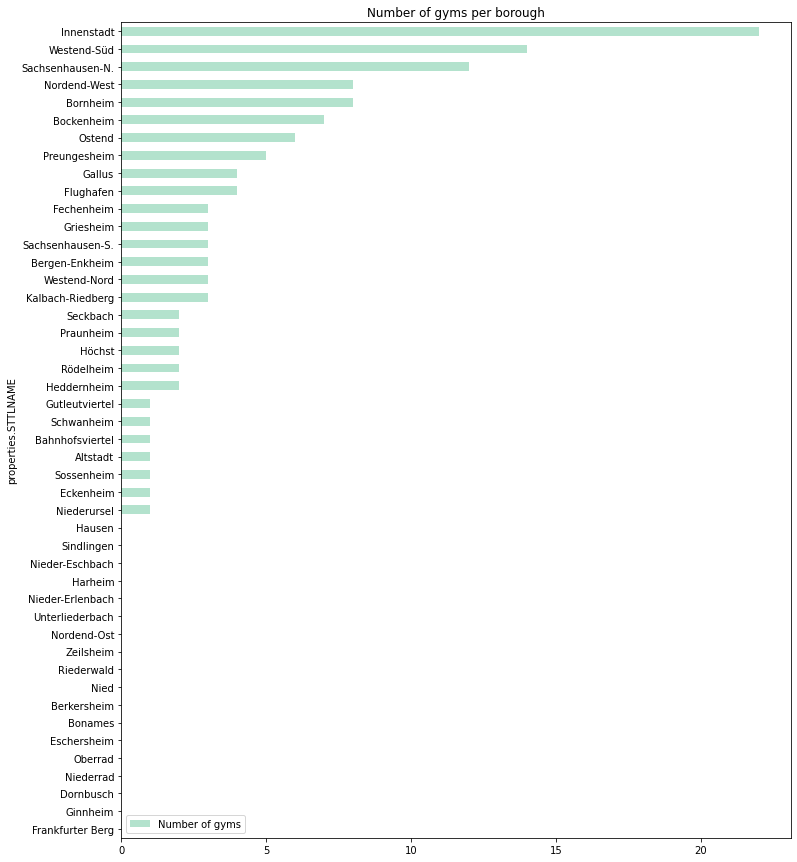

In [29]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Number of gyms',
    x_val='properties.STTLNAME',
    y_val='Number of gyms',
    title='Number of gyms per borough',
    sort_order=True
)

### Introduce self-defined bins regarding gym competition (based on number of gyms in borough)

This competition level will - at some later stage - be used in decision tree analyses as class variable (y).

In [30]:
# Determine into which compeition level for gyms borough
def get_competitionlevel(value):
    if value == 0: return 'None (0)'
    if value > 0 and value < 5: return 'Low (1-4)'
    if value >= 5 and value <= 10: return 'Medium (5-10)'
    if value >= 11: return 'High (10 and more)'

In [31]:
# Populate dataframe with values
ffm_boroughs_shape_df['Gym competition'] = ffm_boroughs_shape_df['Number of gyms'].apply(get_competitionlevel)

### Visualization: Gym competition level (categories / classes)

In [32]:
temp_df = pd.DataFrame(ffm_boroughs_shape_df.groupby('Gym competition')['properties.STTLNR'].nunique())
temp_df = temp_df.rename(columns={'properties.STTLNR':'Number of boroughs'})
temp_df.reset_index(inplace=True)
temp_df.head()

Gym competition  Number of boroughs
0  High (10 and more)                   3
1           Low (1-4)                  20
2       Medium (5-10)                   5
3            None (0)                  18

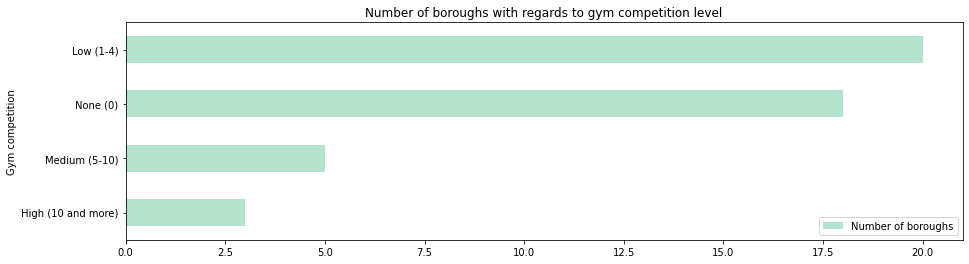

In [33]:
horiz_bar_chart(
    df=temp_df,
    sortcol='Number of boroughs',
    x_val='Gym competition',
    y_val='Number of boroughs',
    title='Number of boroughs with regards to gym competition level',
    sort_order=True,
    figsize_val=(15,4)
)

### Visualization: Types of gyms in each borough

In [34]:
temp_df = pd.DataFrame(ffm_boroughs_shape_df.groupby('Gym competition')['properties.STTLNR'].nunique())
temp_df = temp_df.rename(columns={'properties.STTLNR':'Number of boroughs'})
temp_df.reset_index(inplace=True)
temp_df.head()

Gym competition  Number of boroughs
0  High (10 and more)                   3
1           Low (1-4)                  20
2       Medium (5-10)                   5
3            None (0)                  18

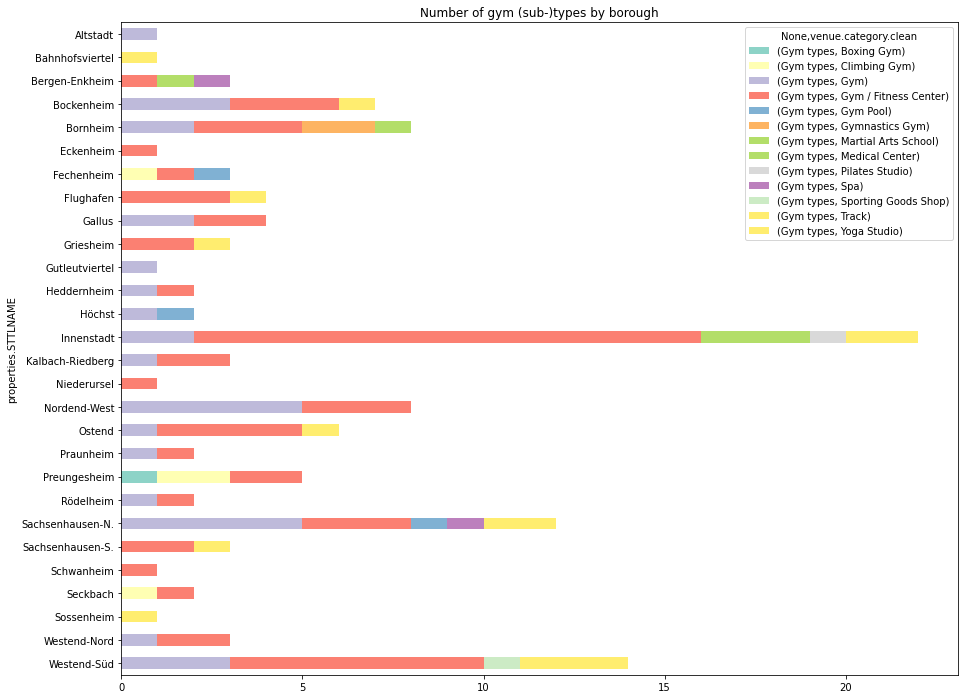

In [35]:
# Step 1: Pre-process data to get appropriate structure for visualization
df_gyms.groupby('venue.category.clean')['properties.STTLNAME'].nunique()
temp_df = pd.DataFrame()
temp_df = pd.DataFrame(df_gyms.groupby(by=['venue.category.clean','properties.STTLNAME'])['properties.STTLNAME'].count())
temp_df.rename(index={'properties.STTLNAME':'Borough name','venue.category.clean':'Venue category'}, columns={'properties.STTLNAME':'Gym types'},inplace=True)
temp_df.rename(index={'venue.category.clean':'Venue category'},inplace=True)
temp_df = temp_df.unstack(level='venue.category.clean',fill_value=np.NaN)
# Step 2: Pre-process data to get appropriate structure for visualization
temp_df.sort_values('properties.STTLNAME',ascending=False).plot.barh(stacked=True,figsize=(15,12),colormap='Set3', title='Number of gym (sub-)types by borough')

# Save the dataframe for a final analysis at the end of the research for the top areas to expand to
gym_categories_df = temp_df

### Visualization: Median gross income by borough

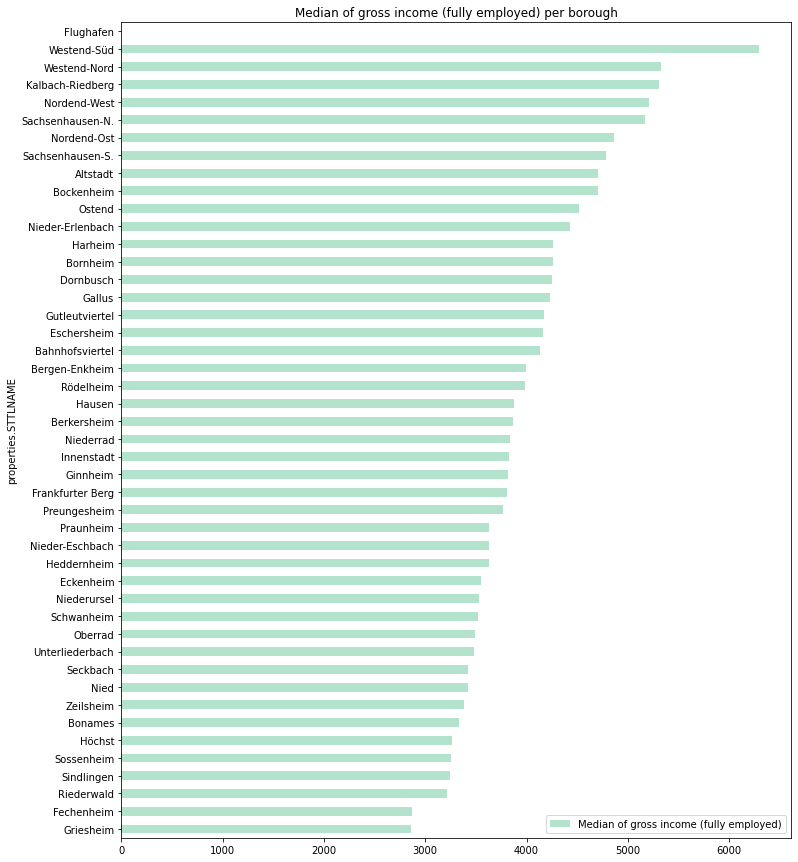

In [36]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Median of gross income (fully employed)',
    x_val='properties.STTLNAME',
    y_val='Median of gross income (fully employed)',
    title='Median of gross income (fully employed) per borough',
    sort_order=True
)

### Visualization: Employment rates

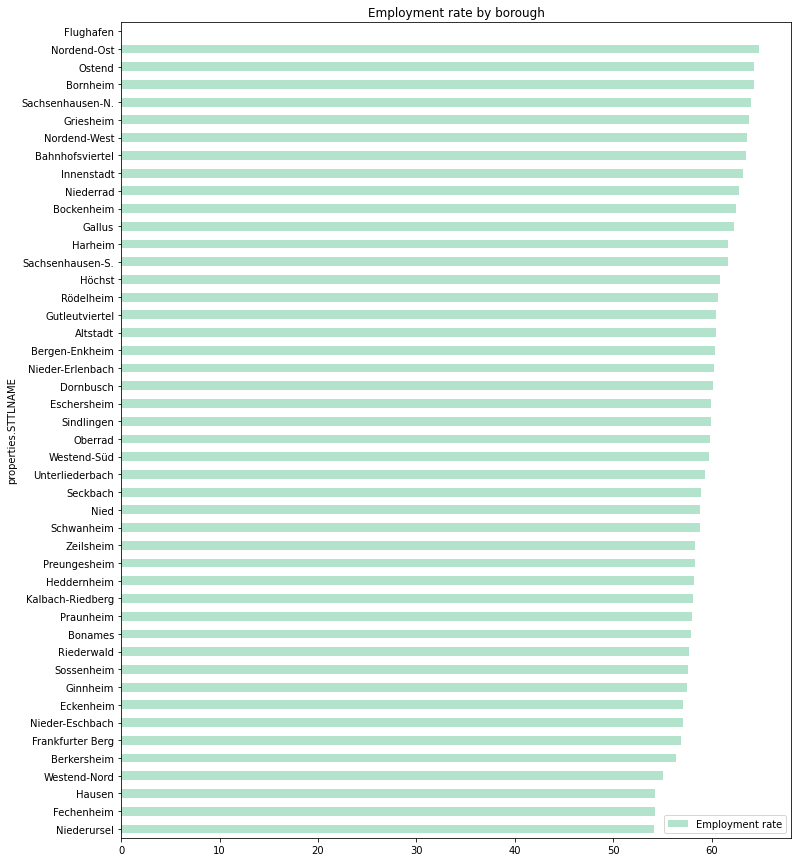

In [37]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Employment rate',
    x_val='properties.STTLNAME',
    y_val='Employment rate',
    title='Employment rate by borough',
    sort_order=True
)

### Visualization: Unemployment rates

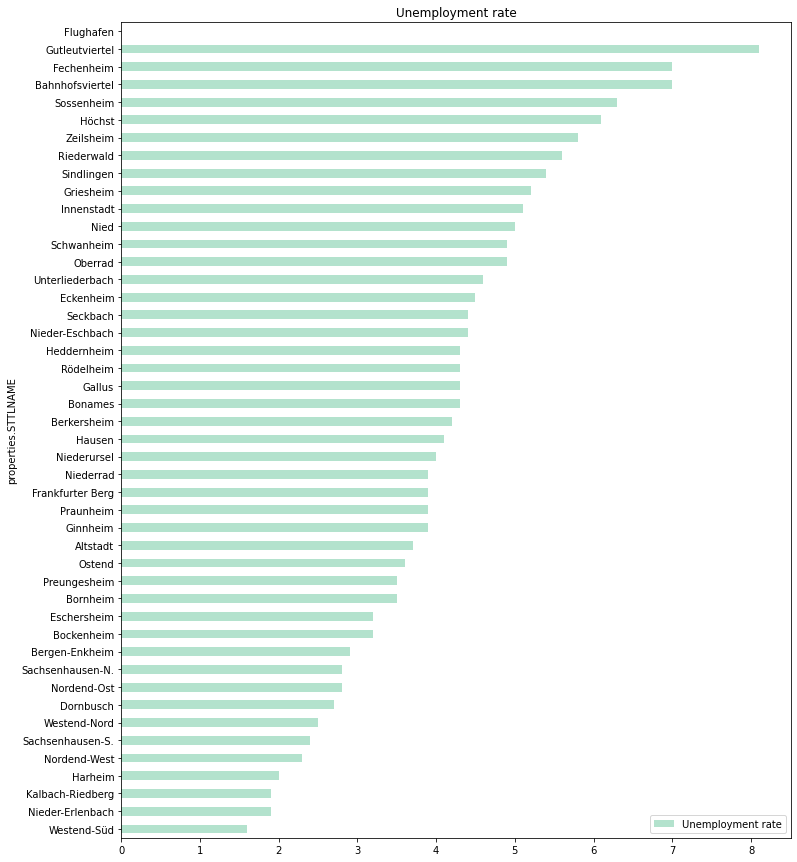

In [38]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Unemployment rate',
    x_val='properties.STTLNAME',
    y_val='Unemployment rate',
    title='Unemployment rate',
    sort_order=True
)

### Visualization: Average age

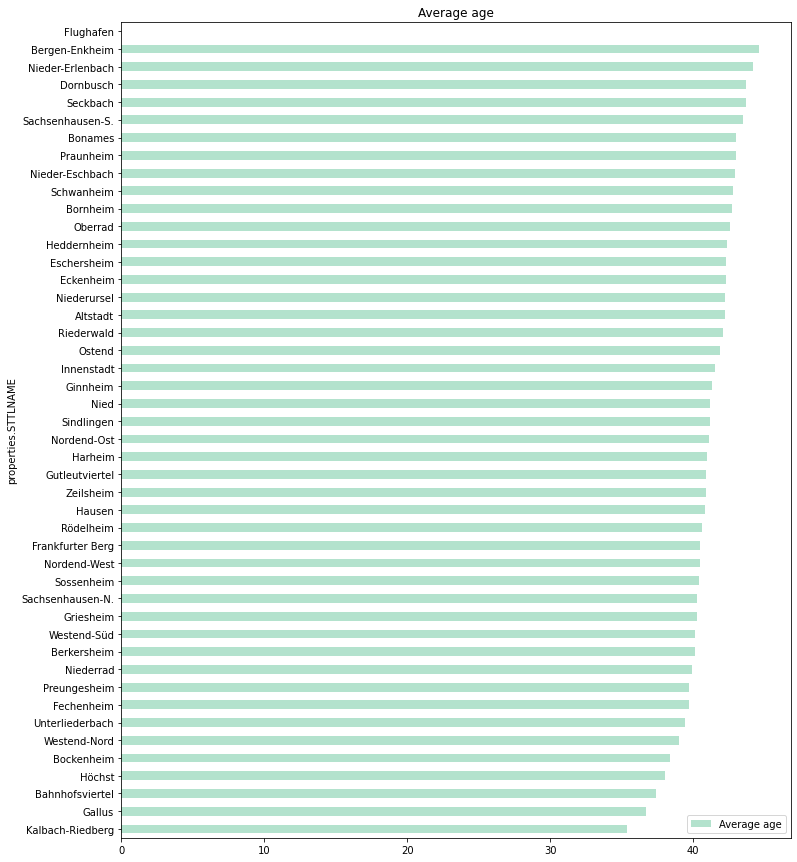

In [39]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Average age',
    x_val='properties.STTLNAME',
    y_val='Average age',
    title='Average age',
    sort_order=True
)

### Visualization: Borough size

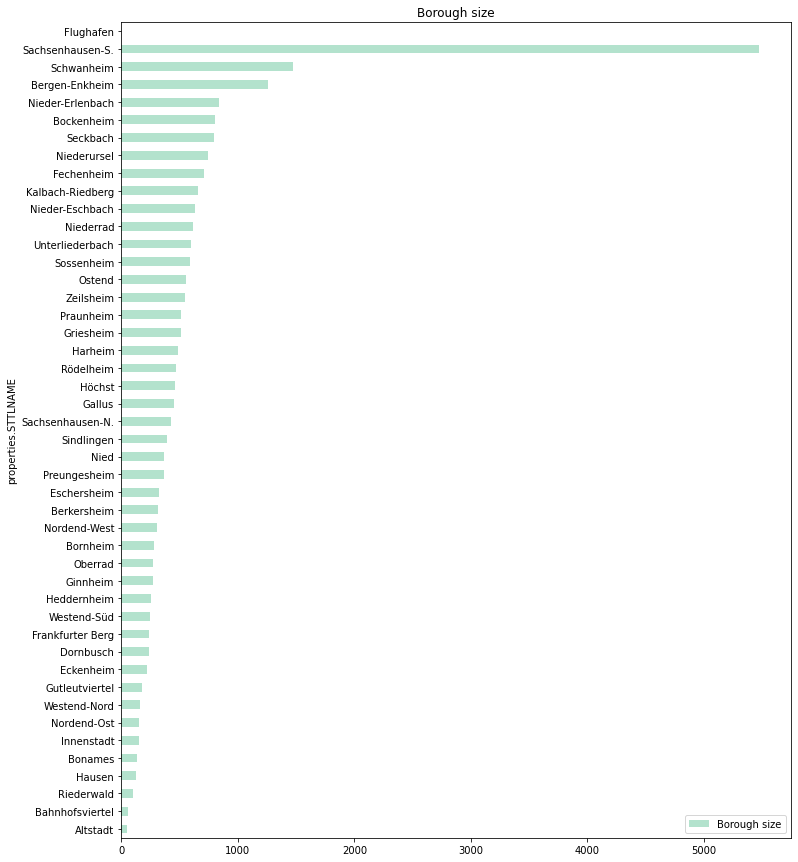

In [40]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Borough size',
    x_val='properties.STTLNAME',
    y_val='Borough size',
    title='Borough size',
    sort_order=True
)

### Visualization: Size of sports, leisure and recreation areas

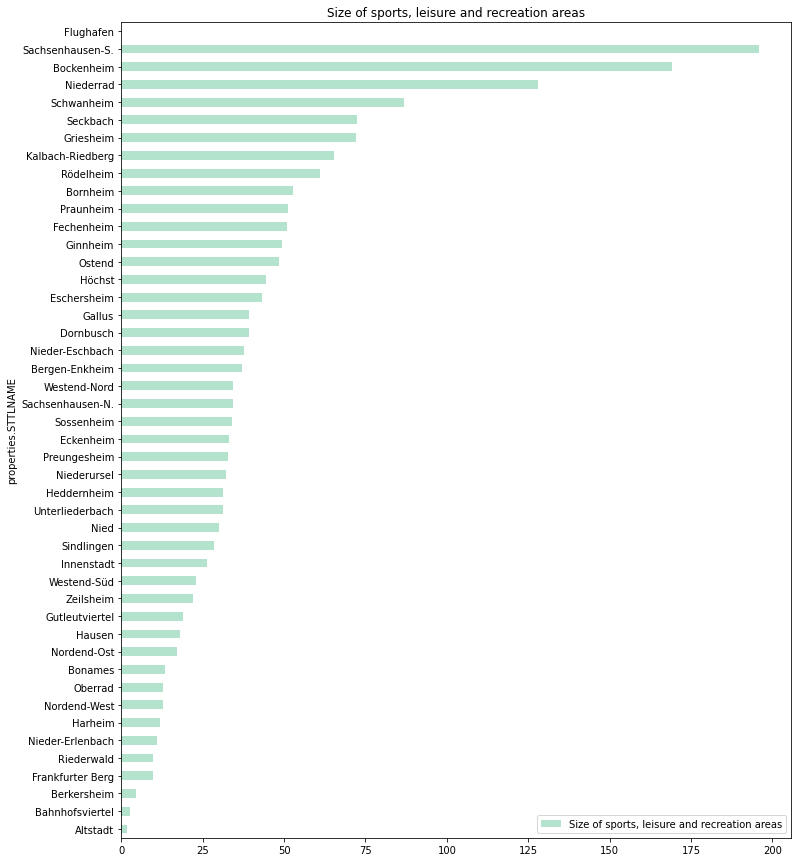

In [41]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Size of sports, leisure and recreation areas',
    x_val='properties.STTLNAME',
    y_val='Size of sports, leisure and recreation areas',
    title='Size of sports, leisure and recreation areas',
    sort_order=True
)

### Visualization: Population density per ha

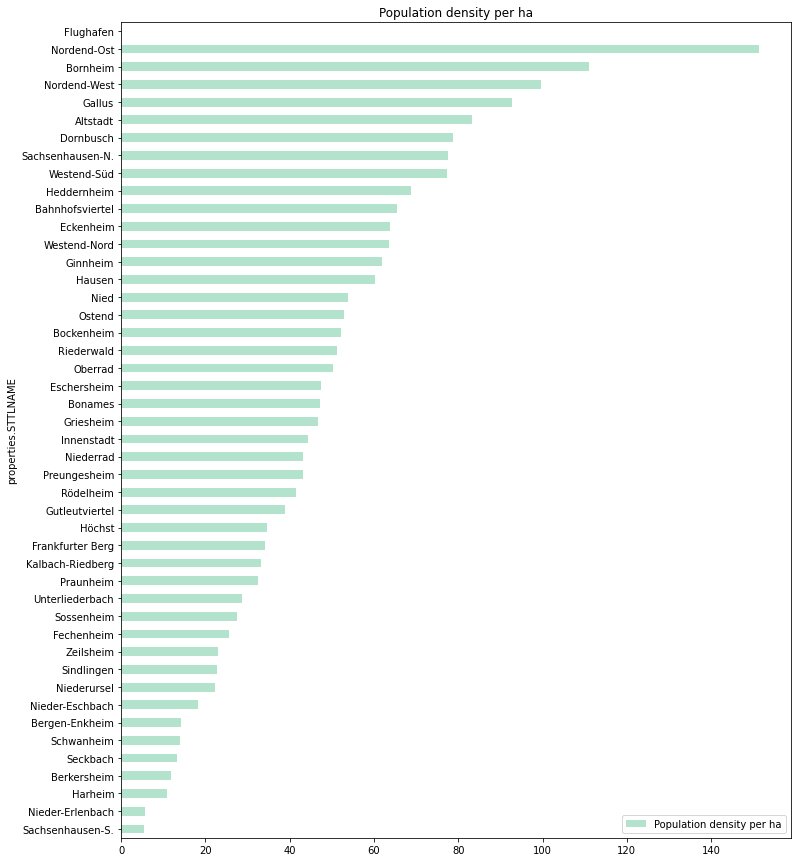

In [42]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Population density per ha',
    x_val='properties.STTLNAME',
    y_val='Population density per ha',
    title='Population density per ha',
    sort_order=True
)

### Explore and visualize data, using several controllable visualization layers

In [43]:
# Get location for Frankfurt city center
address = 'Frankfurt, Germany' # get the general city coordinates

geolocator = Nominatim(user_agent="ffm_explore")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map using latitude and longitude values
ffm_map = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='CartoDB Positron')

# Layer with borough shapes
folium.GeoJson(ffm_boroughs_shape, name="Borough shapes").add_to(ffm_map)

# Create a layer to label the boroughs
borough_labels_layer = folium.FeatureGroup(name="Borough labels")
ffm_map.add_child(borough_labels_layer)

for ind, row in ffm_boroughs_shape_df.iterrows(): 
    value = ffm_boroughs_shape_df.loc[ind,'properties.STTLNAME']
    color = 'darkred'
    # add markers for centers of each borough
    folium.Marker(
        location=[ffm_boroughs_shape_df.loc[ind,'centroid.latitude'], ffm_boroughs_shape_df.loc[ind,'centroid.longitude']],
        icon=folium.DivIcon(html=f"""<div style="color: {color};">{value}</div>""") # help(folium.Icon)
        ).add_to(borough_labels_layer)

# Add the borough centers to the map as a dedicated layer
borough_centers_layer = folium.FeatureGroup(name="Borough centers")
ffm_map.add_child(borough_centers_layer)

for ind, row in ffm_boroughs_shape_df.iterrows(): 
    color='red'
    value = ffm_boroughs_shape_df.loc[ind,'properties.STTLNAME']
    # add markers for centers of each borough
    folium.Marker(
        location=[ffm_boroughs_shape_df.loc[ind,'centroid.latitude'], ffm_boroughs_shape_df.loc[ind,'centroid.longitude']],
        icon=folium.Icon(color='darkred', icon_color='white', icon='info-sign')
        ).add_to(borough_centers_layer)

# Add the gyms in FFM to the map as a dedicated layer
gyms_layer = folium.FeatureGroup(name="Gyms in Frankfurt") # plugins.MarkerCluster(name="Gyms in Frankfurt")
ffm_map.add_child(gyms_layer)

for ind, row in df_gyms.iterrows():
    if df_gyms.loc[ind,'in_ffm']:
        value = df_gyms.loc[ind,'venue.name']
        # add markers for centers of each borough
        folium.Marker(
            location=[df_gyms.loc[ind,'venue.location.lat'], df_gyms.loc[ind,'venue.location.lng']],
            # popup= df_gyms.loc[ind,'venue.name'],
            icon=folium.Icon(color='green', icon_color='white',icon='star',prefix='glyphicon')
            ).add_to(gyms_layer)

# Add the gyms outside of FFM to the map as a dedicated layer
from folium import plugins
gyms_layer_outside = folium.FeatureGroup(name="Gyms outside of Frankfurt") # plugins.MarkerCluster(name="Gyms outside of Frankfurt")
ffm_map.add_child(gyms_layer_outside)

for ind, row in df_gyms.iterrows():
    if df_gyms.loc[ind,'in_ffm'] is False:
        value = df_gyms.loc[ind,'venue.name']
        # add markers for centers of each borough
        folium.Marker(
            location=[df_gyms.loc[ind,'venue.location.lat'], df_gyms.loc[ind,'venue.location.lng']],
            # popup= df_gyms.loc[ind,'venue.name'],
            icon=folium.Icon(color='lightgray', icon_color='white',icon='star-empty',prefix='glyphicon')
            ).add_to(gyms_layer_outside)
        
# Add layer control to the map
folium.LayerControl().add_to(ffm_map)

# display map
ffm_map

### Choropleth maps: Median of gross income of fully employed

In [44]:
# create map using latitude and longitude values
ffm_map2 = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='CartoDB Positron')

# Choropleth map
ffm_map2.choropleth(
        geo_data=ffm_boroughs_shape,
        data=ffm_boroughs_shape_df,
        columns = ['properties.STTLNAME','Median of gross income (fully employed)'],
        key_on='feature.properties.STTLNAME',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name='Median of gross income (fully employed)'
)

# Create a layer to label the boroughs
borough_labels_layer = folium.FeatureGroup(name="Borough labels")
ffm_map2.add_child(borough_labels_layer)

for ind, row in ffm_boroughs_shape_df.iterrows(): 
    value = ffm_boroughs_shape_df.loc[ind,'properties.STTLNAME']
    color = 'darkred'
    # add markers for centers of each borough
    folium.Marker(
        location=[ffm_boroughs_shape_df.loc[ind,'centroid.latitude'], ffm_boroughs_shape_df.loc[ind,'centroid.longitude']],
        icon=folium.DivIcon(html=f"""<div style="color: {color};">{value}</div>""") # help(folium.Icon)
        ).add_to(borough_labels_layer)
    
# Add the gyms in FFM to the map as a dedicated layer
gyms_layer = folium.FeatureGroup(name="Gyms in Frankfurt") # plugins.MarkerCluster(name="Gyms in Frankfurt")
ffm_map2.add_child(gyms_layer)

for ind, row in df_gyms.iterrows():
    if df_gyms.loc[ind,'in_ffm']:
        value = df_gyms.loc[ind,'venue.name']
        # add markers for centers of each borough
        folium.Marker(
            location=[df_gyms.loc[ind,'venue.location.lat'], df_gyms.loc[ind,'venue.location.lng']],
            # popup= df_gyms.loc[ind,'venue.name'],
            icon=folium.Icon(color='green', icon_color='white',icon='star',prefix='glyphicon')
            ).add_to(gyms_layer)

# display map
ffm_map2

### Choropleth maps: Inhabitants

In [45]:
# create map using latitude and longitude values
ffm_map2 = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='CartoDB Positron')

# Choropleth map
ffm_map2.choropleth(
        geo_data=ffm_boroughs_shape,
        data=ffm_boroughs_shape_df,
        columns = ['properties.STTLNAME','Inhabitants'],
        key_on='feature.properties.STTLNAME',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name='Inhabitants'
)

# Create a layer to label the boroughs
borough_labels_layer = folium.FeatureGroup(name="Borough labels")
ffm_map2.add_child(borough_labels_layer)

for ind, row in ffm_boroughs_shape_df.iterrows(): 
    value = ffm_boroughs_shape_df.loc[ind,'properties.STTLNAME']
    color = 'darkred'
    # add markers for centers of each borough
    folium.Marker(
        location=[ffm_boroughs_shape_df.loc[ind,'centroid.latitude'], ffm_boroughs_shape_df.loc[ind,'centroid.longitude']],
        icon=folium.DivIcon(html=f"""<div style="color: {color};">{value}</div>""") # help(folium.Icon)
        ).add_to(borough_labels_layer)
    
# Add the gyms in FFM to the map as a dedicated layer
gyms_layer = folium.FeatureGroup(name="Gyms in Frankfurt") # plugins.MarkerCluster(name="Gyms in Frankfurt")
ffm_map2.add_child(gyms_layer)

for ind, row in df_gyms.iterrows():
    if df_gyms.loc[ind,'in_ffm']:
        value = df_gyms.loc[ind,'venue.name']
        # add markers for centers of each borough
        folium.Marker(
            location=[df_gyms.loc[ind,'venue.location.lat'], df_gyms.loc[ind,'venue.location.lng']],
            # popup= df_gyms.loc[ind,'venue.name'],
            icon=folium.Icon(color='green', icon_color='white',icon='star',prefix='glyphicon')
            ).add_to(gyms_layer)

# display map
ffm_map2

### Choropleth maps: Population density per ha

In [46]:
# create map using latitude and longitude values
ffm_map2 = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='CartoDB Positron')

# Choropleth map
ffm_map2.choropleth(
        geo_data=ffm_boroughs_shape,
        data=ffm_boroughs_shape_df,
        columns = ['properties.STTLNAME','Population density per ha'],
        key_on='feature.properties.STTLNAME',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name='Population density per ha'
)

# Create a layer to label the boroughs
borough_labels_layer = folium.FeatureGroup(name="Borough labels")
ffm_map2.add_child(borough_labels_layer)

for ind, row in ffm_boroughs_shape_df.iterrows(): 
    value = ffm_boroughs_shape_df.loc[ind,'properties.STTLNAME']
    color = 'darkred'
    # add markers for centers of each borough
    folium.Marker(
        location=[ffm_boroughs_shape_df.loc[ind,'centroid.latitude'], ffm_boroughs_shape_df.loc[ind,'centroid.longitude']],
        icon=folium.DivIcon(html=f"""<div style="color: {color};">{value}</div>""") # help(folium.Icon)
        ).add_to(borough_labels_layer)
    
# Add the gyms in FFM to the map as a dedicated layer
gyms_layer = folium.FeatureGroup(name="Gyms in Frankfurt") # plugins.MarkerCluster(name="Gyms in Frankfurt")
ffm_map2.add_child(gyms_layer)

for ind, row in df_gyms.iterrows():
    if df_gyms.loc[ind,'in_ffm']:
        value = df_gyms.loc[ind,'venue.name']
        # add markers for centers of each borough
        folium.Marker(
            location=[df_gyms.loc[ind,'venue.location.lat'], df_gyms.loc[ind,'venue.location.lng']],
            # popup= df_gyms.loc[ind,'venue.name'],
            icon=folium.Icon(color='green', icon_color='white',icon='star',prefix='glyphicon')
            ).add_to(gyms_layer)

# display map
ffm_map2

### Choropleth maps: Size of sports, leisure and recreation areas

In [47]:
# create map using latitude and longitude values
ffm_map2 = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='CartoDB Positron')

# Choropleth map
ffm_map2.choropleth(
        geo_data=ffm_boroughs_shape,
        data=ffm_boroughs_shape_df,
        columns = ['properties.STTLNAME','Size of sports, leisure and recreation areas'],
        key_on='feature.properties.STTLNAME',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name='Size of sports, leisure and recreation areas'
)

# Create a layer to label the boroughs
borough_labels_layer = folium.FeatureGroup(name="Borough labels")
ffm_map2.add_child(borough_labels_layer)

for ind, row in ffm_boroughs_shape_df.iterrows(): 
    value = ffm_boroughs_shape_df.loc[ind,'properties.STTLNAME']
    color = 'darkred'
    # add markers for centers of each borough
    folium.Marker(
        location=[ffm_boroughs_shape_df.loc[ind,'centroid.latitude'], ffm_boroughs_shape_df.loc[ind,'centroid.longitude']],
        icon=folium.DivIcon(html=f"""<div style="color: {color};">{value}</div>""") # help(folium.Icon)
        ).add_to(borough_labels_layer)
    
# Add the gyms in FFM to the map as a dedicated layer
gyms_layer = folium.FeatureGroup(name="Gyms in Frankfurt") # plugins.MarkerCluster(name="Gyms in Frankfurt")
ffm_map2.add_child(gyms_layer)

for ind, row in df_gyms.iterrows():
    if df_gyms.loc[ind,'in_ffm']:
        value = df_gyms.loc[ind,'venue.name']
        # add markers for centers of each borough
        folium.Marker(
            location=[df_gyms.loc[ind,'venue.location.lat'], df_gyms.loc[ind,'venue.location.lng']],
            # popup= df_gyms.loc[ind,'venue.name'],
            icon=folium.Icon(color='green', icon_color='white',icon='star',prefix='glyphicon')
            ).add_to(gyms_layer)

# display map
ffm_map2

### Enhance feature selection for a subsequent clustering analysis via a DecisionTree analysis

<b>Note of caution:</b> Based on the given data, the decision tree results vary across different runs. Hence results are just used as additional information, but feature selection should have some additional theoretic assumptions.

It should be noted that causality might be questioned, but correlations might occur.

For the decision tree analysis, the gym competition level is used as primary target as shown below. This ensures better legibility of the results, and it can be argued that number of gyms as continuous variable might be to granular and yields many more depth levels.

In [48]:
from sklearn import tree

# ffm_boroughs_shape_df.reset_index(inplace=True)
features_df = ffm_boroughs_shape_df.dropna()
X = features_df[[    
    'Borough size',
    'Size of sports, leisure and recreation areas',
    'Households',
    'Inhabitants',
    'female',
    'male',
    'People per household',
    'Population density per ha',
    'Average age',
    'Employment total',
    'Employment rate',
    'Unemployment rate',
    'Median of gross income (fully employed)']].values
Y = features_df['Gym competition'].values
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X, Y)

In [49]:
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)

decision_tree_text = tree.export_text(decision_tree,
              feature_names=[
                        'Borough size',
                        'Size of sports, leisure and recreation areas',
                        'Households',
                        'Inhabitants',
                        'female',
                        'male',
                        'People per household',
                        'Population density per ha',
                        'Average age',
                        'Employment total',
                        'Employment rate',
                        'Unemployment rate',
                        'Median of gross income (fully employed)'
              ],
               max_depth=10
            )
print(decision_tree_text)

|--- Size of sports, leisure and recreation areas <= 31.28
|   |--- People per household <= 1.79
|   |   |--- female <= 3079.50
|   |   |   |--- class: Low (1-4)
|   |   |--- female >  3079.50
|   |   |   |--- male <= 10306.00
|   |   |   |   |--- class: High (10 and more)
|   |   |   |--- male >  10306.00
|   |   |   |   |--- Population density per ha <= 125.50
|   |   |   |   |   |--- class: Medium (5-10)
|   |   |   |   |--- Population density per ha >  125.50
|   |   |   |   |   |--- class: None (0)
|   |--- People per household >  1.79
|   |   |--- class: None (0)
|--- Size of sports, leisure and recreation areas >  31.28
|   |--- People per household <= 1.77
|   |   |--- Unemployment rate <= 3.00
|   |   |   |--- class: High (10 and more)
|   |   |--- Unemployment rate >  3.00
|   |   |   |--- class: Medium (5-10)
|   |--- People per household >  1.77
|   |   |--- Median of gross income (fully employed) <= 3625.26
|   |   |   |--- class: Low (1-4)
|   |   |--- Median of gross inc

As a result, the <b> size of a boroughs' sports, leisure and recreation areas </b>  seems to impact the competition level significantly when using 'Gym competition' as target variable. <b>Hence a ratio of those areas compared to the overall borough size is going to be computed for subsequent analyses<b>.</br>
Besides, as might expected, some additional variables seem to be relevant:
- households
- people per household
- employment
- median gross income
- population density
- average age

If the decision tree is run on 'Number of gyms', the following additional variables correlate:
- unemployment rate
- employment rate
- borough size
- inhabitants

### Compute and visualize ratios of <i>sports, leisure and recreation area</i> to <i>overall borough size</i>

In [50]:
# Determine into which compeition level for gyms borough
def get_area_ratio(sports_area, total_area):
    result = sports_area / total_area
    return result

In [51]:
# Populate dataframe with values
ffm_boroughs_shape_df['Sports, recreation and leisure ratio'] = ffm_boroughs_shape_df['Size of sports, leisure and recreation areas'] / ffm_boroughs_shape_df['Borough size']

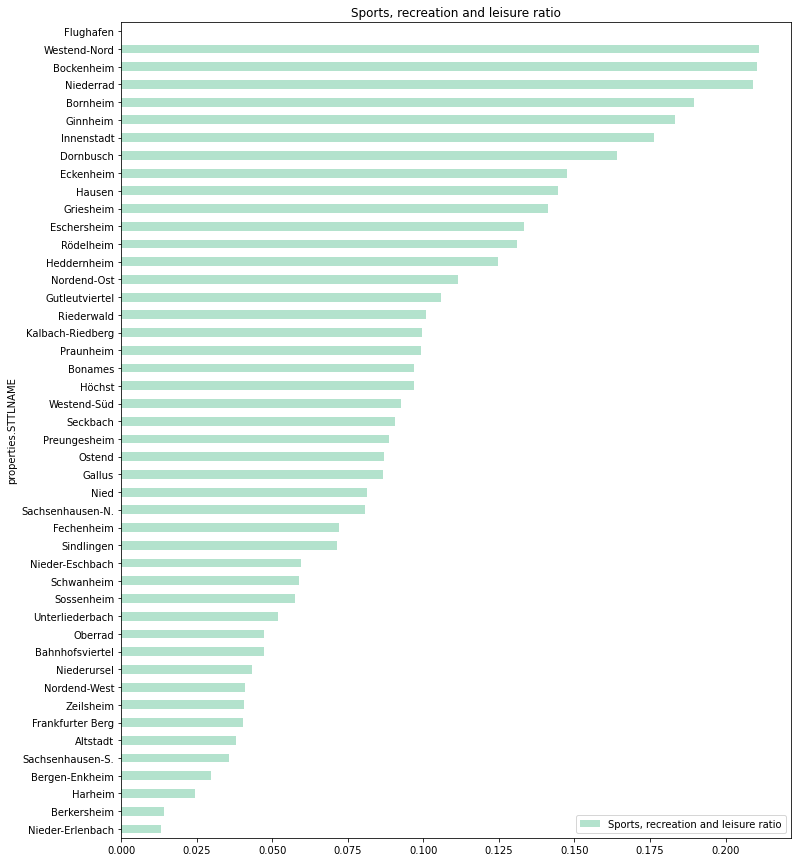

In [52]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Sports, recreation and leisure ratio',
    x_val='properties.STTLNAME',
    y_val='Sports, recreation and leisure ratio',
    title='Sports, recreation and leisure ratio',
    sort_order=True
)

### Choropleth maps: Sports, recreation and leisure ratio

In [53]:
# create map using latitude and longitude values
ffm_map2 = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='CartoDB Positron')

# Choropleth map
ffm_map2.choropleth(
        geo_data=ffm_boroughs_shape,
        data=ffm_boroughs_shape_df,
        columns = ['properties.STTLNAME','Sports, recreation and leisure ratio'],
        key_on='feature.properties.STTLNAME',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name='Sports, recreation and leisure ratio'
)

# Create a layer to label the boroughs
borough_labels_layer = folium.FeatureGroup(name="Borough labels")
ffm_map2.add_child(borough_labels_layer)

for ind, row in ffm_boroughs_shape_df.iterrows(): 
    value = ffm_boroughs_shape_df.loc[ind,'properties.STTLNAME']
    color = 'darkred'
    # add markers for centers of each borough
    folium.Marker(
        location=[ffm_boroughs_shape_df.loc[ind,'centroid.latitude'], ffm_boroughs_shape_df.loc[ind,'centroid.longitude']],
        icon=folium.DivIcon(html=f"""<div style="color: {color};">{value}</div>""") # help(folium.Icon)
        ).add_to(borough_labels_layer)
    
# Add the gyms in FFM to the map as a dedicated layer
gyms_layer = folium.FeatureGroup(name="Gyms in Frankfurt") # plugins.MarkerCluster(name="Gyms in Frankfurt")
ffm_map2.add_child(gyms_layer)

for ind, row in df_gyms.iterrows():
    if df_gyms.loc[ind,'in_ffm']:
        value = df_gyms.loc[ind,'venue.name']
        # add markers for centers of each borough
        folium.Marker(
            location=[df_gyms.loc[ind,'venue.location.lat'], df_gyms.loc[ind,'venue.location.lng']],
            # popup= df_gyms.loc[ind,'venue.name'],
            icon=folium.Icon(color='green', icon_color='white',icon='star',prefix='glyphicon')
            ).add_to(gyms_layer)

# display map
ffm_map2

### Revisit decision tree using ratio instead of total size

<b>Note of caution:</b> Based on the given data, the decision tree results vary across different runs. Hence results are just used as additional information, but feature selection should have some additional theoretic assumptions.

In [54]:
from sklearn import tree

# ffm_boroughs_shape_df.reset_index(inplace=True)
features_df = ffm_boroughs_shape_df.dropna()
X = features_df[[    
    'Borough size',
    'Sports, recreation and leisure ratio',
    'Households',
    'Inhabitants',
    'female',
    'male',
    'People per household',
    'Population density per ha',
    'Average age',
    'Employment total',
    'Employment rate',
    'Unemployment rate',
    'Median of gross income (fully employed)']].values
Y = features_df['Gym competition'].values
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X, Y)

In [55]:
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)

decision_tree_text = tree.export_text(decision_tree,
              feature_names=[
                        'Borough size',
                        'Sports, recreation and leisure ratio',
                        'Households',
                        'Inhabitants',
                        'female',
                        'male',
                        'People per household',
                        'Population density per ha',
                        'Average age',
                        'Employment total',
                        'Employment rate',
                        'Unemployment rate',
                        'Median of gross income (fully employed)'
              ],
               max_depth=10
            )
print(decision_tree_text)

|--- Households <= 17062.50
|   |--- Unemployment rate <= 5.95
|   |   |--- Borough size <= 646.59
|   |   |   |--- People per household <= 2.00
|   |   |   |   |--- People per household <= 1.86
|   |   |   |   |   |--- People per household <= 1.81
|   |   |   |   |   |   |--- female <= 9885.00
|   |   |   |   |   |   |   |--- Sports, recreation and leisure ratio <= 0.07
|   |   |   |   |   |   |   |   |--- class: Low (1-4)
|   |   |   |   |   |   |   |--- Sports, recreation and leisure ratio >  0.07
|   |   |   |   |   |   |   |   |--- Sports, recreation and leisure ratio <= 0.19
|   |   |   |   |   |   |   |   |   |--- class: High (10 and more)
|   |   |   |   |   |   |   |   |--- Sports, recreation and leisure ratio >  0.19
|   |   |   |   |   |   |   |   |   |--- class: Low (1-4)
|   |   |   |   |   |   |--- female >  9885.00
|   |   |   |   |   |   |   |--- class: None (0)
|   |   |   |   |   |--- People per household >  1.81
|   |   |   |   |   |   |--- class: None (0)
|   |   | 

### Select features and normalize data for subsequent cluster analysis and for creation of an index 'Target areas for gym franchise expansions and/or gym openings'

Several scaling methods were run to identify most suitable. As expected and according to SKLearn documentation, MaxAbsScaler returned the 2nd best and most meaningful results for this datset since the dataset has only few observations since it is largely based on aggregate data by borough already. The Normalize sclaer was discareded since it's intended for using in text mining analyses.

In [56]:
# Select features for KMeans cluster analysis
features = ffm_boroughs_shape_df.dropna(axis=0)[[
    'Borough size',
    'Sports, recreation and leisure ratio',
    'Inhabitants',
    'Average age',
    'Employment total',
    'Employment rate',
    'Unemployment rate',
    'Median of gross income (fully employed)',
    'Number of gyms'
    ]]

In [57]:
# Normalize the data, small sample size and not evenly distirbuted, hence using MaxAbsScaler 
scaler = sklearn.preprocessing.MaxAbsScaler()

# MinMaxScaler : -5.706863
# MaxAbsScaler : -2.970728
# StandardScaler : -117.457233
# RobustScaler : -148.989608
# Normalizer : -0.045164
# QuantileTransformer : -10.129711
# PowerTransformer: -113.490674

features_scaled = scaler.fit_transform(features)

In [58]:
features_scaled.shape

(45, 9)

### Perform cluster analysis to group the boroughs based on the selected features

In [59]:
# Use grid search to optimize number of clusters for kmeans clustering analysis

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Define Search Parameters
kclusters = np.arange(2,30,1).tolist() # set a range of clusters to perform a grid search to discover optimum number of clusters
random_range = np.arange(0,10,1).tolist() + np.arange(10,100,10).tolist() + np.arange(100,1001,100).tolist()
search_params = {'n_clusters': kclusters, # range of cluster sizes to iterate
                 'random_state':[42], # ensure results are going to be repeatable in future executions
                 'max_iter':[100],
                }

# Init the Model
kmeans = KMeans()

# Init Grid Search Class
model = GridSearchCV(kmeans, param_grid=search_params)

# Do the Grid Search
model.fit(features_scaled)

# Best Model and set value of labels / clusters for use in map display
best_kmeans_model = model.best_estimator_
kclusters = model.best_params_['n_clusters']

pd.set_option('display.max_columns', None)
results_gridsearch = pd.DataFrame(model.cv_results_).sort_values('rank_test_score')

C:\Users\A2712835\AppData\Local\WPy64-3800\python-3.8.0.amd64\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


### Visualize gridsearch results to determine how many clusters will be used in final KMeans algorithm

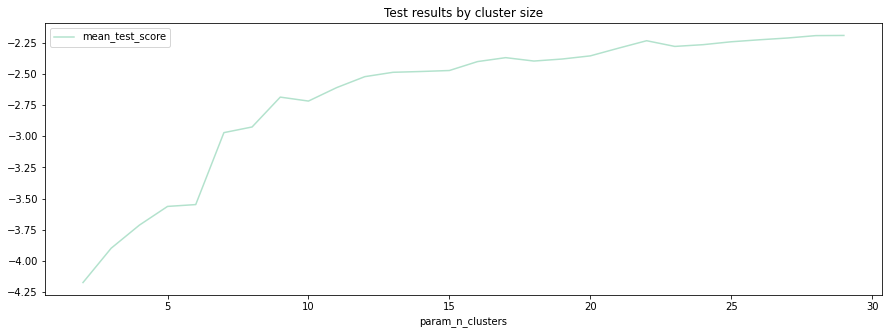

In [60]:
line_chart(results_gridsearch,x_val='param_n_clusters',y_val=['mean_test_score'],title='Test results by cluster size',sortcol='param_n_clusters',figsize_val=(15,5))

In [61]:
# Show top results from grid search
results_gridsearch.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
27       0.078000      0.000819         0.000000        0.000000   
26       0.075000      0.001415         0.000667        0.000471   
25       0.073001      0.000818         0.000333        0.000471   

   param_max_iter param_n_clusters param_random_state  \
27            100               29                 42   
26            100               28                 42   
25            100               27                 42   

                                               params  split0_test_score  \
27  {'max_iter': 100, 'n_clusters': 29, 'random_st...          -4.439968   
26  {'max_iter': 100, 'n_clusters': 28, 'random_st...          -4.439968   
25  {'max_iter': 100, 'n_clusters': 27, 'random_st...          -4.439968   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
27          -1.310322          -0.820569        -2.190286        1.603281   
26          -1.310322          -0.824621        -2.191637        1.602128   
25          -1.310322          -0.882288        -2.210859        1.585874   

    rank_test_score  
27                1  
26                2  
25                3

### Determine alternative measures via yet another grid search to assess number of clusters (silhouette coefficients, Sum of squared distances of samples to their closest cluster center)

In [62]:
# Compute silhouette coefficient and Sum of squared distances of samples to their closest cluster center
from sklearn.metrics import silhouette_score
kclusters = np.arange(2,30,1).tolist() # set a range of clusters to perform a grid search to discover optimum number of clusters
grid_results_df = pd.DataFrame(columns={'k','inertia','silhouette_coeff'})

for k in kclusters:
    kmeans = KMeans(n_clusters=k, random_state=42,max_iter=100)
    kmeans.fit(features_scaled)
    grid_results_df = grid_results_df.append({'k':k,'inertia':kmeans.inertia_,'silhouette_coeff':silhouette_score(features_scaled, kmeans.labels_)},ignore_index=True)

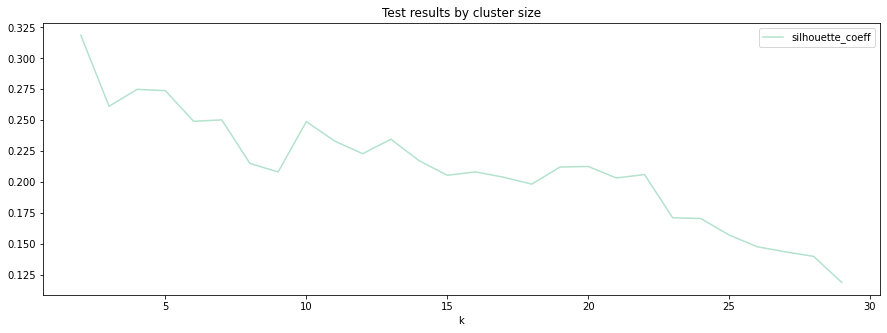

In [63]:
# Visualize results
line_chart(grid_results_df,x_val='k',y_val=['silhouette_coeff'],title='Test results by cluster size',sortcol='k',figsize_val=(15,5))

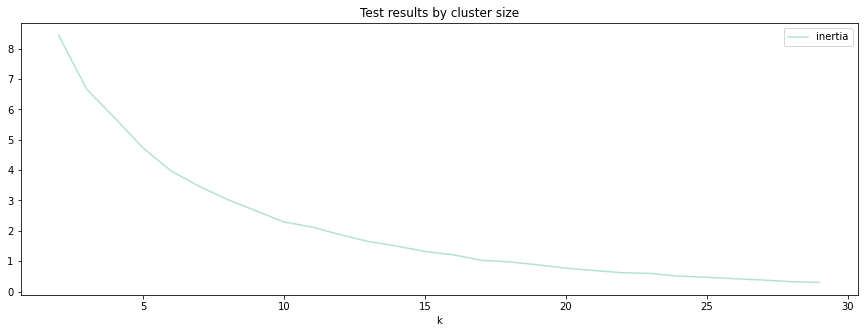

In [64]:
# Visualize results
line_chart(grid_results_df,x_val='k',y_val=['inertia'],title='Test results by cluster size',sortcol='k',figsize_val=(15,5))

### Decide on cluster size & predict cluster

Since it is meaningful to balance number of clusters vs. test score and given the curve in the grid search results, a cluster size of 9 is chosen (to have a sufficient but not too finegrained clustering). Random state will the same as in the gridsearch.

In [65]:
# Predict cluster and assign to dataframe
kmeans = KMeans(n_clusters=9,random_state=42)
kmeans.fit(features_scaled)
kmeans_results = kmeans.predict(features_scaled)

In [66]:
# Aiport has no data, hence we use -1 to indicate we have no cluster being predicted
position_airport = ffm_boroughs_shape_df.index[ffm_boroughs_shape_df['properties.STTLNAME']=='Flughafen'].tolist()
kmeans_results_withairport = np.insert(kmeans_results,obj=position_airport,values=-1)

In [67]:
# Assign the cluster results to the dataframe, for all boroughs except airpot which had to be dropped due to missing information
for ind, row in ffm_boroughs_shape_df.iterrows():
    ffm_boroughs_shape_df.loc[ind,'Cluster'] = kmeans_results_withairport[ind]

# Set the cluster for the airport borough back to NaN
ffm_boroughs_shape_df.loc[position_airport,'Cluster'] = np.NaN

### Create index for target boroughs to establish a new gym

In [68]:
# Revenue potential

ffm_boroughs_shape_df['Amount of total income of employed inhabitants'] = ffm_boroughs_shape_df['Inhabitants'] * ffm_boroughs_shape_df['Employment rate'] * ffm_boroughs_shape_df['Median of gross income (fully employed)']

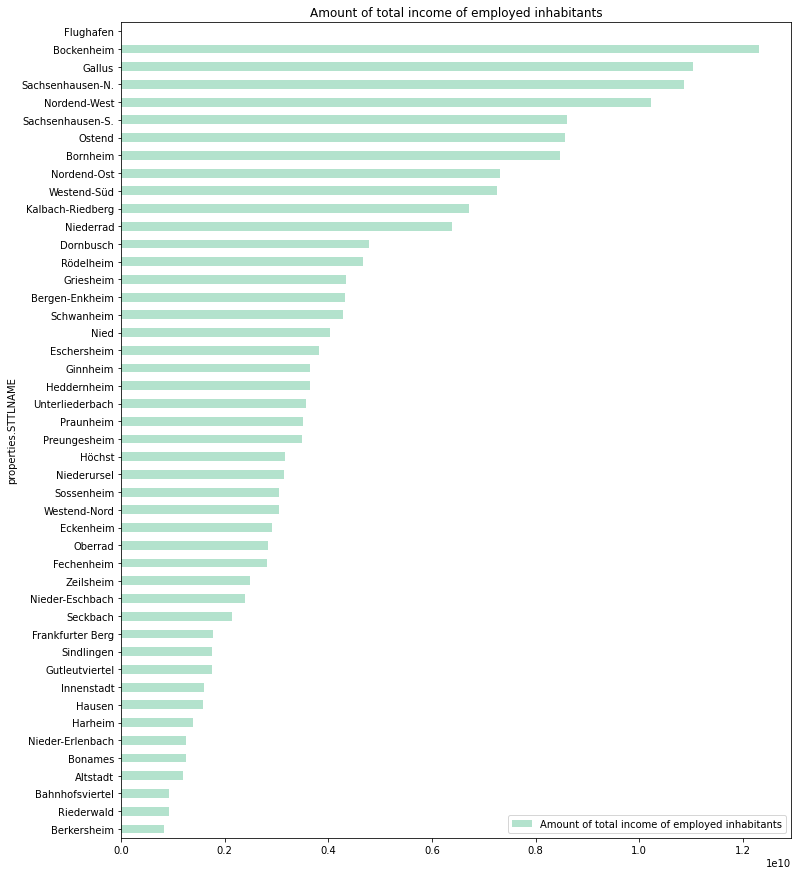

In [69]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Amount of total income of employed inhabitants',
    x_val='properties.STTLNAME',
    y_val='Amount of total income of employed inhabitants',
    title='Amount of total income of employed inhabitants',
    sort_order=True
)

In [70]:
features = ffm_boroughs_shape_df.dropna(axis=0)[[
    'Amount of total income of employed inhabitants', #1 - positive effect on index
    'Sports, recreation and leisure ratio', #2 - negative effect on index
    'Number of gyms' #3 - negative effect on index
    ]]

In [71]:
# Normalize the data, small sample size and not evenly distirbuted, hence using MaxAbsScaler 
scaler = sklearn.preprocessing.MaxAbsScaler()
features_scaled = scaler.fit_transform(features)

In [72]:
# Compute index for targeting borough for opening gym (startup or expansion of existing gym franchise)
# index = 
#          + Scaled value of result of ( inhabitants * employment rate * median of gross income )
#          - Scaled value of result of ( Ratio of sports, leisure & recreation areas + Number of gyms ), weighted 50% for each type of competitive offers

index = features_scaled[:,0] - (0.5 * features_scaled[:,1] + 0.5 * features_scaled[:,2] )

In [73]:
# Aiport has no data, hence we use -1 to indicate we have no cluster being predicted
position_airport = ffm_boroughs_shape_df.index[ffm_boroughs_shape_df['properties.STTLNAME']=='Flughafen'].tolist()
index_withairport = np.insert(index,obj=position_airport,values=np.NaN)

In [74]:
# Assign the cluster results to the dataframe, for all boroughs except airpot which had to be dropped due to missing information
for ind, row in ffm_boroughs_shape_df.iterrows():
    ffm_boroughs_shape_df.loc[ind,'Gym expansion - target index'] = index_withairport[ind]

### Visualize the index in which areas to try to expand / open gyms

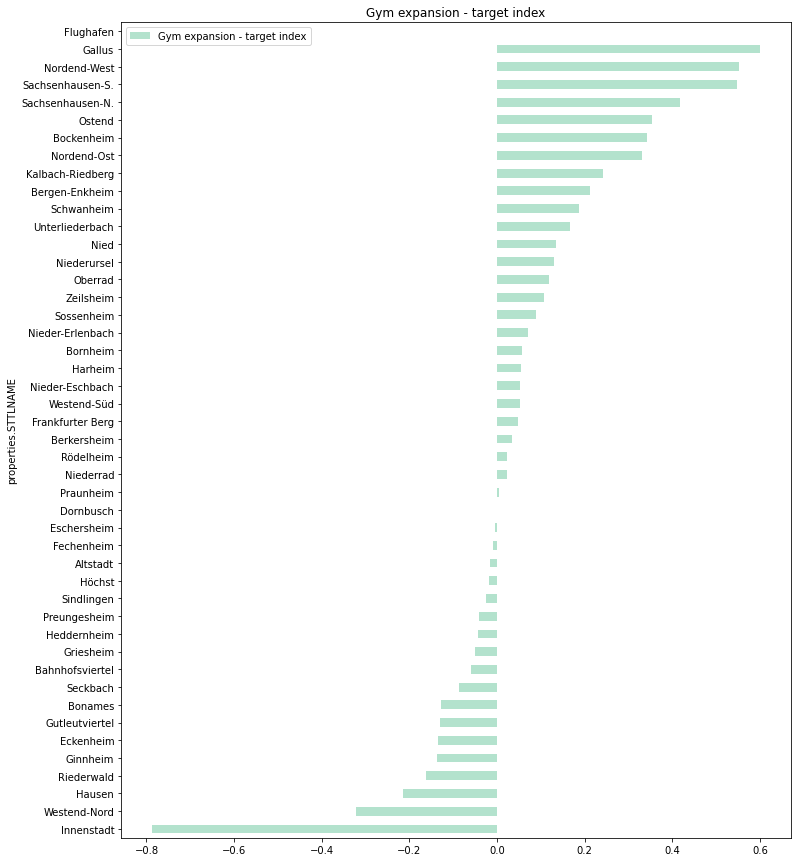

In [75]:
horiz_bar_chart(
    df=ffm_boroughs_shape_df,
    sortcol='Gym expansion - target index',
    x_val='properties.STTLNAME',
    y_val='Gym expansion - target index',
    title='Gym expansion - target index',
    sort_order=True
)

Top boroughs to expand would be 
- Gallus
- Nordend-West
- Sachsenhausen Süd
- Sachsenhausen Nord
- Ostend

### Statistics for top10 target boroughs for gym expansion

In [76]:
# Display information about the top5 boroughs to expand into
top10_expand_df = ffm_boroughs_shape_df[[
    'properties.STTLNAME',
    'Gym expansion - target index',
    'centroid.latitude',
    'centroid.longitude',
    'Number of gyms',
    'Gym competition',
    'Borough size',
    'Size of sports, leisure and recreation areas',
    'Sports, recreation and leisure ratio',
    'Population density per ha',
    'Inhabitants',
    'female',
    'male',
    'Average age',
    'Households',
    'People per household',
    'Employment rate',
    'Unemployment rate',
    'Median of gross income (fully employed)',
    'Amount of total income of employed inhabitants',
    'Cluster']].sort_values('Gym expansion - target index',ascending=False).head(10)

In [77]:
# Show all information for the top 10 boroughs for expansion
pd.merge(top10_expand_df,gym_categories_df,how='left',on='properties.STTLNAME').transpose()

C:\Users\A2712835\AppData\Local\WPy64-3800\python-3.8.0.amd64\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


0  \
properties.STTLNAME                                         Gallus   
Gym expansion - target index                              0.600595   
centroid.latitude                                        50.102319   
centroid.longitude                                        8.638973   
Number of gyms                                                 4.0   
Gym competition                                          Low (1-4)   
Borough size                                            451.730563   
Size of sports, leisure and recreation areas             39.183601   
Sports, recreation and leisure ratio                      0.086741   
Population density per ha                                92.645934   
Inhabitants                                                41851.0   
female                                                     19824.0   
male                                                       22027.0   
Average age                                                   36.7   
Households                                                 23069.0   
People per household                                          1.85   
Employment rate                                               62.3   
Unemployment rate                                              4.3   
Median of gross income (fully employed)                 4235.34252   
Amount of total income of employed inhabitants  11042881823.000393   
Cluster                                                        4.0   
(Gym types, Boxing Gym)                                        NaN   
(Gym types, Climbing Gym)                                      NaN   
(Gym types, Gym)                                               2.0   
(Gym types, Gym / Fitness Center)                              2.0   
(Gym types, Gym Pool)                                          NaN   
(Gym types, Gymnastics Gym)                                    NaN   
(Gym types, Martial Arts School)                               NaN   
(Gym types, Medical Center)                                    NaN   
(Gym types, Pilates Studio)                                    NaN   
(Gym types, Spa)                                               NaN   
(Gym types, Sporting Goods Shop)                               NaN   
(Gym types, Track)                                             NaN   
(Gym types, Yoga Studio)                                       NaN   

                                                                 1  \
properties.STTLNAME                                   Nordend-West   
Gym expansion - target index                              0.552259   
centroid.latitude                                        50.130401   
centroid.longitude                                        8.685188   
Number of gyms                                                 8.0   
Gym competition                                      Medium (5-10)   
Borough size                                            310.017541   
Size of sports, leisure and recreation areas             12.689284   
Sports, recreation and leisure ratio                      0.040931   
Population density per ha                                99.662103   
Inhabitants                                                30897.0   
female                                                     15845.0   
male                                                       15052.0   
Average age                                                   40.5   
Households                                                 18568.0   
People per household                                          1.69   
Employment rate                                               63.6   
Unemployment rate                                              2.3   
Median of gross income (fully employed)                5206.382353   
Amount of total income of employed inhabitants  10230797477.541176   
Cluster                                                        4.0   
(Gym types, Boxing Gym)                                        NaN   
(Gym

### Choropleth maps: Visualize index to pursue gym franchise expansion or gym startup

In [78]:
# create map using latitude and longitude values
ffm_map2 = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='CartoDB Positron')

# Choropleth map
ffm_map2.choropleth(
        geo_data=ffm_boroughs_shape,
        data=ffm_boroughs_shape_df,
        columns = ['properties.STTLNAME','Gym expansion - target index'],
        key_on='feature.properties.STTLNAME',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name='Gym expansion - target index'
)

# Create a layer to label the boroughs
borough_labels_layer = folium.FeatureGroup(name="Borough labels")
ffm_map2.add_child(borough_labels_layer)

for ind, row in ffm_boroughs_shape_df.iterrows(): 
    value = ffm_boroughs_shape_df.loc[ind,'properties.STTLNAME']
    color = 'darkred'
    # add markers for centers of each borough
    folium.Marker(
        location=[ffm_boroughs_shape_df.loc[ind,'centroid.latitude'], ffm_boroughs_shape_df.loc[ind,'centroid.longitude']],
        icon=folium.DivIcon(html=f"""<div style="color: {color};">{value}</div>""") # help(folium.Icon)
        ).add_to(borough_labels_layer)
    
# Add the gyms in FFM to the map as a dedicated layer
gyms_layer = folium.FeatureGroup(name="Gyms in Frankfurt") # plugins.MarkerCluster(name="Gyms in Frankfurt")
ffm_map2.add_child(gyms_layer)

for ind, row in df_gyms.iterrows():
    if df_gyms.loc[ind,'in_ffm']:
        value = df_gyms.loc[ind,'venue.name']
        # add markers for centers of each borough
        folium.Marker(
            location=[df_gyms.loc[ind,'venue.location.lat'], df_gyms.loc[ind,'venue.location.lng']],
            # popup= df_gyms.loc[ind,'venue.name'],
            icon=folium.Icon(color='green', icon_color='white',icon='star',prefix='glyphicon')
            ).add_to(gyms_layer)

# display map
ffm_map2

### Choropleth maps: Results from the cluster analysis

In [79]:
# create map using latitude and longitude values
ffm_map2 = folium.Map(location=[latitude, longitude], zoom_start=12,tiles='CartoDB Positron')

# Choropleth map
ffm_map2.choropleth(
        geo_data=ffm_boroughs_shape,
        data=ffm_boroughs_shape_df,
        columns = ['properties.STTLNAME','Cluster'],
        key_on='feature.properties.STTLNAME',
        fill_color='Set3', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name='Cluster'
)

# Create a layer to label the boroughs
borough_labels_layer = folium.FeatureGroup(name="Borough labels")
ffm_map2.add_child(borough_labels_layer)

for ind, row in ffm_boroughs_shape_df.iterrows(): 
    value = ffm_boroughs_shape_df.loc[ind,'properties.STTLNAME'] + '\\nCluster: '+ str(ffm_boroughs_shape_df.loc[ind,'Cluster'])
    color = 'darkred'
    # add markers for centers of each borough
    folium.Marker(
        location=[ffm_boroughs_shape_df.loc[ind,'centroid.latitude'], ffm_boroughs_shape_df.loc[ind,'centroid.longitude']],
        icon=folium.DivIcon(html=f"""<div style="color: {color};">{value}</div>""") # help(folium.Icon)
        ).add_to(borough_labels_layer)
    
# Add the gyms in FFM to the map as a dedicated layer
gyms_layer = folium.FeatureGroup(name="Gyms in Frankfurt") # plugins.MarkerCluster(name="Gyms in Frankfurt")
ffm_map2.add_child(gyms_layer)

for ind, row in df_gyms.iterrows():
    if df_gyms.loc[ind,'in_ffm']:
        value = df_gyms.loc[ind,'venue.name']
        # add markers for centers of each borough
        folium.Marker(
            location=[df_gyms.loc[ind,'venue.location.lat'], df_gyms.loc[ind,'venue.location.lng']],
            # popup= df_gyms.loc[ind,'venue.name'],
            icon=folium.Icon(color='green', icon_color='white',icon='star',prefix='glyphicon')
            ).add_to(gyms_layer)

# display map
ffm_map2

### Describe the clusters retrieved from KMeans clustering (including the gym expansion index)

In [80]:
describe_clusters = ffm_boroughs_shape_df[[
    'properties.STTLNAME',
    'Gym expansion - target index',
    'Number of gyms',
    'Gym competition',
    'Borough size',
    'Size of sports, leisure and recreation areas',
    'Sports, recreation and leisure ratio',
    'Population density per ha',
    'Inhabitants',
    'female',
    'male',
    'Average age',
    'Households',
    'People per household',
    'Employment rate',
    'Unemployment rate',
    'Median of gross income (fully employed)',
    'Amount of total income of employed inhabitants',
    'Cluster']].groupby('Cluster')

In [81]:
describe_clusters.describe(include='all').transpose()

Cluster                                                               0.0  \
properties.STTLNAME                            count                    1   
                                               unique                   1   
                                               top             Innenstadt   
                                               freq                     1   
                                               mean                   NaN   
                                               std                    NaN   
                                               min                    NaN   
                                               25%                    NaN   
                                               50%                    NaN   
                                               75%                    NaN   
                                               max                    NaN   
Gym expansion - target index                   count                  1.0   
                                               unique                 NaN   
                                               top                    NaN   
                                               freq                   NaN   
                                               mean             -0.788249   
                                               std                    NaN   
                                               min              -0.788249   
                                               25%              -0.788249   
                                               50%              -0.788249   
                                               75%              -0.788249   
                                               max              -0.788249   
Number of gyms                                 count                  1.0   
                                               unique                 NaN   
                                               top                    NaN   
                                               freq                   NaN   
                                               mean                  22.0   
                                               std                    NaN   
                                               min                   22.0   
                                               25%                   22.0   
                                               50%                   22.0   
                                               75%                   22.0   
                                               max                   22.0   
Gym competition                                count                    1   
                                               unique                   1   
                                               top     High (10 and more)   
                                               freq                     1   
                                               mean                   NaN   
                                               std                    NaN   
                                               min                    NaN   
                                               25%                    NaN   
                                               50%                    NaN   
                                               75%                    NaN   
                                               max                    NaN   
Borough size                                   count                  1.0   
                                               unique                 NaN   
                                               top                    NaN   
                                               freq                   NaN   
                                               mean            149.107237   
                                               std                    NaN   
                                               min             149.107237